In [1]:
import pandas as pd
import matplotlib as plt
import datetime
import typing
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_csv('../DATA/processed/dataset.csv', parse_dates=['date'])
data = data.set_index('date')

In [3]:
wind_dir = {'Ветер, дующий с востока': 0,
            'Ветер, дующий с востоко-северо-востока': 45/2,
            'Ветер, дующий с северо-востока': 45,
            'Ветер, дующий с северо-северо-востока': 45 + 45/2,
            'Ветер, дующий с севера': 90,
            'Ветер, дующий с северо-северо-запад': 90 + 45/2,
            'Ветер, дующий с северо-запада': 135,
            'Ветер, дующий с западо-северо-запада': 135 + 45/2,
            'Ветер, дующий с запада': 180,
            'Ветер, дующий с западо-юго-запада': 180+45/2,
            'Ветер, дующий с юго-запада': 225,
            'Ветер, дующий с юго-юго-запада': 225 + 45/2,
            'Ветер, дующий с юга': 270,
            'Ветер, дующий с юго-юго-востока': 270 + 45/2,
            'Ветер, дующий с юго-востока': 315,
            'Ветер, дующий с востоко-юго-востока': 315 + 45/2,
            'Штиль, безветрие': None,
            }

In [4]:
def prepare_features(data: pd.DataFrame) -> pd.DataFrame:
    """Features preparation for anomaly detection and clustering"""
    # textual values encoding
    data['hum_meteo'] = data.hum_meteo.fillna(method='bfill')
    data['pres_meteo'] = data.hum_meteo.fillna(method='bfill')
    data['wind_speed'] = data.hum_meteo.fillna(method='bfill')
    data['temp_meteo'] = data.temp_meteo.fillna(method='bfill')
    data['prec_amount'] = data.prec_amount.fillna(method='bfill')
    data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
    data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
    data['prec_amount'] = data.prec_amount.astype(float)

    
    # fill missing value before PCA
    data['P1'] = data.P1.interpolate()
    
    for c in data.columns:
        data[c].fillna((data[c].mean()), inplace=True)
    
    return data

In [5]:
sel_columns = ['P1','hum_meteo', 'temp_meteo', 'pres_meteo', 'wind_speed', 'prec_amount']

In [6]:
data = data[sel_columns]
data = prepare_features(data)

In [7]:
data['day_of_week'] = data.index.dayofweek
data['weekend'] = data.day_of_week.apply(lambda d: d == 5 or d == 6).astype(int)
data['hour'] = data.index.hour
data['night'] = data.hour.apply(lambda h: 0<= h < 7).astype(int)
data['morning'] = data.hour.apply(lambda h: 7<= h < 12).astype(int)
data['day'] = data.hour.apply(lambda h: 12<= h < 17).astype(int)
data['evening'] = data.hour.apply(lambda h: 17<= h < 24).astype(int)
data['sin_day'] = np.sin(2*np.pi*data.day_of_week/7)
data['cos_day'] = np.cos(2*np.pi*data.day_of_week/7)
data['sin_hour'] = np.sin(2*np.pi*data.hour/24)
data['cos_hour'] = np.cos(2*np.pi*data.hour/24)

data.drop(columns=['day_of_week', 'hour', 'night', 'day', 'morning', 'evening'], inplace=True)
data.head()

,P1,hum_meteo,temp_meteo,pres_meteo,wind_speed,prec_amount,weekend,sin_day,cos_day,sin_hour,cos_hour
date,,,,,,,,,,,
2019-04-01 00:00:00,5.645000,59.0,6.7,59.0,59.0,0.0,0,0.0,1.0,0.0,1.0
2019-04-01 00:05:00,5.513333,59.0,6.7,59.0,59.0,0.0,0,0.0,1.0,0.0,1.0
2019-04-01 00:10:00,5.504643,59.0,6.7,59.0,59.0,0.0,0,0.0,1.0,0.0,1.0
2019-04-01 00:15:00,6.790714,59.0,6.7,59.0,59.0,0.0,0,0.0,1.0,0.0,1.0
2019-04-01 00:20:00,7.344643,59.0,6.7,59.0,59.0,0.0,0,0.0,1.0,0.0,1.0


In [8]:
for c in data.columns:
    if data[c].isnull().values.any():
        print(c)

# Add lag variable

In [9]:
data.columns

Index(['P1', 'hum_meteo', 'temp_meteo', 'pres_meteo', 'wind_speed',
       'prec_amount', 'weekend', 'sin_day', 'cos_day', 'sin_hour', 'cos_hour'],
      dtype='object')

In [10]:
columns = ['P1',
           'temp_meteo',
           'hum_meteo',
           'wind_speed',
           'prec_amount',
          ]

In [11]:
shift_values = [1, 2, 4, 8, 16, 32, 64, 12*24]

In [12]:
for c in columns:
    for s in shift_values:
        data[f'{c}_shift_{s}'] = data[c].shift(s)

In [13]:
data = data[str(data.index[0]+datetime.timedelta(minutes=(5*int(np.max(shift_values)+1)))):]

In [14]:
data.head()

,P1,hum_meteo,temp_meteo,pres_meteo,wind_speed,prec_amount,weekend,sin_day,cos_day,sin_hour,...,wind_speed_shift_64,wind_speed_shift_288,prec_amount_shift_1,prec_amount_shift_2,prec_amount_shift_4,prec_amount_shift_8,prec_amount_shift_16,prec_amount_shift_32,prec_amount_shift_64,prec_amount_shift_288
date,,,,,,,,,,,,,,,,,,,,,
2019-04-02 00:05:00,6.453333,81.0,1.5,81.0,81.0,0.0,0,0.781831,0.62349,0.0,...,80.0,59.0,0.0,0.3,0.3,0.3,0.3,0.3,0.3,0.0
2019-04-02 00:10:00,6.015000,81.0,1.5,81.0,81.0,0.0,0,0.781831,0.62349,0.0,...,80.0,59.0,0.0,0.0,0.3,0.3,0.3,0.3,0.3,0.0
2019-04-02 00:15:00,5.991071,81.0,1.5,81.0,81.0,0.0,0,0.781831,0.62349,0.0,...,80.0,59.0,0.0,0.0,0.3,0.3,0.3,0.3,0.3,0.0
2019-04-02 00:20:00,5.867500,81.0,1.5,81.0,81.0,0.0,0,0.781831,0.62349,0.0,...,80.0,59.0,0.0,0.0,0.0,0.3,0.3,0.3,0.3,0.0
2019-04-02 00:25:00,6.085595,81.0,1.5,81.0,81.0,0.0,0,0.781831,0.62349,0.0,...,80.0,59.0,0.0,0.0,0.0,0.3,0.3,0.3,0.3,0.0


# Train test split

In [15]:
sel_columns = ['hum_meteo', 'temp_meteo', 'pres_meteo', 'wind_speed', 'prec_amount']

In [16]:
y = data.P1
data = data.drop(columns='P1')

In [17]:
idx_split = str(data.index[-1]-datetime.timedelta(days=4))
idx_split


'2020-01-24 00:00:00'

In [18]:
X_test = data[idx_split:]
X_train = data[:idx_split]
y_test = y[idx_split:]
y_train = y[:idx_split]

In [19]:
X_train.columns, X_test.columns

(Index(['hum_meteo', 'temp_meteo', 'pres_meteo', 'wind_speed', 'prec_amount',
        'weekend', 'sin_day', 'cos_day', 'sin_hour', 'cos_hour', 'P1_shift_1',
        'P1_shift_2', 'P1_shift_4', 'P1_shift_8', 'P1_shift_16', 'P1_shift_32',
        'P1_shift_64', 'P1_shift_288', 'temp_meteo_shift_1',
        'temp_meteo_shift_2', 'temp_meteo_shift_4', 'temp_meteo_shift_8',
        'temp_meteo_shift_16', 'temp_meteo_shift_32', 'temp_meteo_shift_64',
        'temp_meteo_shift_288', 'hum_meteo_shift_1', 'hum_meteo_shift_2',
        'hum_meteo_shift_4', 'hum_meteo_shift_8', 'hum_meteo_shift_16',
        'hum_meteo_shift_32', 'hum_meteo_shift_64', 'hum_meteo_shift_288',
        'wind_speed_shift_1', 'wind_speed_shift_2', 'wind_speed_shift_4',
        'wind_speed_shift_8', 'wind_speed_shift_16', 'wind_speed_shift_32',
        'wind_speed_shift_64', 'wind_speed_shift_288', 'prec_amount_shift_1',
        'prec_amount_shift_2', 'prec_amount_shift_4', 'prec_amount_shift_8',
        'prec_amount_shif

In [20]:
scaler = StandardScaler()
col = X_train.columns
X_train[col] = scaler.fit_transform(X_train[col])
#X_test[col] = scaler.transform(X_test[col])

//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [21]:
#poly = PolynomialFeatures(2)
#X_train = poly.fit_transform(X_train)
#X_test = poly.transform(X_test)
#names = poly.get_feature_names(columns)

In [22]:
for c in X_train.columns:
    if data[c].isnull().values.any():
        print(c)

In [23]:
for c in X_test.columns:
    if data[c].isnull().values.any():
        print(c)

In [24]:
def predict(X_test, model, scaler, y: typing.List):
    start_idx = X_test.index[0] + datetime.timedelta(minutes=5*int(np.max(shift_values)))
    X = X_test[str(start_idx):]
    i = len(y)
    split = i
    for index, row in X.iterrows():
        columns = ['P1']
        for c in columns:
            for s in shift_values:
                row.loc[f'{c}_shift_{s}'] = y[i-s]
        row = scaler.transform(row.values.reshape(1, -1))
        p = model.predict(row)
        #print(p)
        y = np.append(y, p)
        i += 1
    prediction =y[split:]
    return prediction

In [25]:
X_test = X_test.drop(columns=[f'{c}_shift_{s}' for c in ['P1'] for s in shift_values])
X_test.head()

,hum_meteo,temp_meteo,pres_meteo,wind_speed,prec_amount,weekend,sin_day,cos_day,sin_hour,cos_hour,...,wind_speed_shift_64,wind_speed_shift_288,prec_amount_shift_1,prec_amount_shift_2,prec_amount_shift_4,prec_amount_shift_8,prec_amount_shift_16,prec_amount_shift_32,prec_amount_shift_64,prec_amount_shift_288
date,,,,,,,,,,,,,,,,,,,,,
2020-01-24 00:00:00,-0.042431,-1.833724,-0.042431,-0.042431,-0.329753,0,-0.623527,-1.272826,1.644691e-18,1.414214,...,-0.197643,0.371219,-0.329753,-0.329754,-0.329758,-0.329766,-0.329781,-0.329811,-0.329872,1.167481
2020-01-24 00:05:00,64.000000,-4.000000,64.000000,64.000000,0.000000,0,-0.433884,-0.900969,0.000000e+00,1.000000,...,61.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
2020-01-24 00:10:00,64.000000,-4.000000,64.000000,64.000000,0.000000,0,-0.433884,-0.900969,0.000000e+00,1.000000,...,61.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
2020-01-24 00:15:00,64.000000,-4.000000,64.000000,64.000000,0.000000,0,-0.433884,-0.900969,0.000000e+00,1.000000,...,61.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
2020-01-24 00:20:00,64.000000,-4.000000,64.000000,64.000000,0.000000,0,-0.433884,-0.900969,0.000000e+00,1.000000,...,61.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


In [26]:
X_train = X_train[str(data.index[-1]-datetime.timedelta(days=30)):]
y_train = y_train[str(data.index[-1]-datetime.timedelta(days=30)):]

In [27]:
model = Lasso(alpha=3.0)
model.fit(X_train, y_train)
start_idx = X_test.index[0] + datetime.timedelta(minutes=5*int(np.max(shift_values)))
prediction = predict(X_test, model, scaler, y_test[:str(start_idx)].values)

In [28]:
mean_absolute_error(y_test[str(y_test.index[0] + datetime.timedelta(minutes=5*int(np.max(shift_values)))):], prediction)

2.96854403197419

In [29]:
result = pd.DataFrame(index=y_test[str(start_idx):].index)
result['y_test'] = y_test[str(start_idx):].values
result['pred'] = prediction

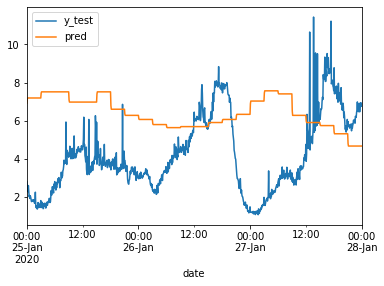

In [30]:
result.plot()

# Use 10 series for validation

In [44]:
y = data.P1
data = data.drop(columns='P1')

In [45]:
idx_split = str(data.index[-1]-datetime.timedelta(days=4*10))
idx_split


'2019-12-19 00:00:00'

In [46]:
X_test = data[idx_split:]
X_train = data[:idx_split]
y_test = y[idx_split:]
y_train = y[:idx_split]

In [47]:
scaler = StandardScaler()
col = X_train.columns
X_train[col] = scaler.fit_transform(X_train[col])
#X_test[col] = scaler.transform(X_test[col])

//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [48]:
def predict(X_test, model, scaler, y: typing.List):
    start_idx = X_test.index[0] + datetime.timedelta(minutes=5*int(np.max(shift_values)))
    X = X_test[str(start_idx):]
    i = len(y)
    split = i
    for index, row in X.iterrows():
        columns = ['P1']
        for c in columns:
            for s in shift_values:
                row.loc[f'{c}_shift_{s}'] = y[i-s]
        row = scaler.transform(row.values.reshape(1, -1))
        p = model.predict(row)
        #print(p)
        y = np.append(y, p)
        i += 1
    prediction =y[split:]
    return prediction

In [49]:
X_test = X_test.drop(columns=[f'{c}_shift_{s}' for c in ['P1'] for s in shift_values])
X_test.head()

,hum_meteo,temp_meteo,pres_meteo,wind_speed,prec_amount,weekend,sin_day,cos_day,sin_hour,cos_hour,...,wind_speed_shift_64,wind_speed_shift_288,prec_amount_shift_1,prec_amount_shift_2,prec_amount_shift_4,prec_amount_shift_8,prec_amount_shift_16,prec_amount_shift_32,prec_amount_shift_64,prec_amount_shift_288
date,,,,,,,,,,,,,,,,,,,,,
2019-12-19 00:00:00,1.14655,-0.819572,1.14655,1.14655,-0.181664,0,0.602826,-1.279058,1.069454e-18,1.414214,...,1.40482,1.257624,0.152448,0.152452,0.152461,0.152479,0.152514,0.152585,0.152727,-0.324209
2019-12-19 00:05:00,85.00000,6.400000,85.00000,85.00000,0.300000,0,0.433884,-0.900969,0.000000e+00,1.000000,...,90.00000,87.000000,0.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2019-12-19 00:10:00,85.00000,6.400000,85.00000,85.00000,0.300000,0,0.433884,-0.900969,0.000000e+00,1.000000,...,90.00000,87.000000,0.300000,0.300000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2019-12-19 00:15:00,85.00000,6.400000,85.00000,85.00000,0.300000,0,0.433884,-0.900969,0.000000e+00,1.000000,...,90.00000,87.000000,0.300000,0.300000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2019-12-19 00:20:00,85.00000,6.400000,85.00000,85.00000,0.300000,0,0.433884,-0.900969,0.000000e+00,1.000000,...,90.00000,87.000000,0.300000,0.300000,0.300000,1.000000,1.000000,1.000000,1.000000,0.000000


In [50]:
test_series = [g for n, g in X_test.groupby(pd.Grouper(freq='4D'))][:10]
y_test_series = [g for n, g in y_test.groupby(pd.Grouper(freq='4D'))][:10]
len(test_series)

10

In [51]:
model = Lasso(alpha=3.0)
model.fit(X_train, y_train)

val = []
for ts, ys in zip(test_series, y_test_series):
    start_idx = ts.index[0] + datetime.timedelta(minutes=5*int(np.max(shift_values)))
    prediction = predict(ts, model, scaler, ys[:str(start_idx)].values)
    val.append(prediction)
    

In [52]:
scores = []
for i, ys in zip(val, y_test_series):
    score = mean_absolute_error(ys[str(ys.index[0] + datetime.timedelta(minutes=5*int(np.max(shift_values)))):], i)
    scores.append(score)
scores

[28.352580399093018,
 59.478520306972435,
 11.526188796782085,
 4.613976367016513,
 2.8982484644898796,
 15.200299533014107,
 4.430832492722174,
 12.501080629088404,
 2.3512928710773404,
 2.429611177560587]

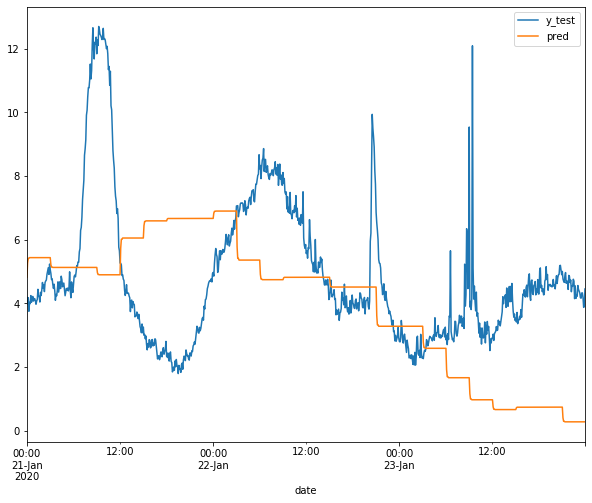

In [56]:
pred = val[8]
correct = y_test_series[8]
start_idx = correct.index[0] + datetime.timedelta(minutes=5*int(np.max(shift_values)))
result = pd.DataFrame(index=correct[str(start_idx):].index)
result['y_test'] = correct[str(start_idx):].values
result['pred'] = pred
result.plot()